# 서울시 모기발생상황 지표 예측  
2016년~ 2019년까지의 일별 모기지수 데이터를 온도,강수량 데이터를 통해 예측해본다.  
[코드 예시](https://www.datamanim.com/dataset/03_dataq/q2/mos/main.html)



In [ ]:
import pandas as pd
train_x =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/train_x.csv',encoding='euc-kr')
train_y =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/train_y.csv',encoding='euc-kr')
test_x =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/test_x.csv',encoding='euc-kr')
sub    =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/sub.csv')

In [ ]:
print(train_x.shape, test_x.shape, train_y.shape, sub.shape)

In [3]:
train_x.head()

,date,강수량(mm),평균기온(℃),최저기온(℃),최고기온(℃)
0,2019-12-31,0.0,-7.9,-10.9,-4.5
1,2019-12-30,0.4,2.7,-5.7,6.8
2,2019-12-29,1.4,3.8,1.1,6.2
3,2019-12-27,0.0,-1.7,-4.6,2.6
4,2019-12-25,0.0,2.0,-2.7,6.6


In [4]:
# 결측치 보기
for df in [train_x, train_y, test_x]:
    print(df.isnull().sum())
    print('='*50)

date       0
강수량(mm)    0
평균기온(℃)    0
최저기온(℃)    0
최고기온(℃)    0
dtype: int64
date              0
mosquito_ratio    0
dtype: int64
date       0
강수량(mm)    0
평균기온(℃)    0
최저기온(℃)    0
최고기온(℃)    0
dtype: int64


In [5]:
# 요약통계량
train_x.describe()

,강수량(mm),평균기온(℃),최저기온(℃),최고기온(℃)
count,1016.000000,1016.000000,1016.000000,1016.000000
mean,3.566240,14.000886,9.833465,18.924902
std,13.489043,10.988587,11.161832,11.126918
min,0.000000,-14.800000,-17.800000,-10.700000
25%,0.000000,4.300000,0.200000,9.200000
50%,0.000000,16.250000,11.000000,21.700000
75%,0.500000,23.300000,19.425000,28.200000
max,144.500000,33.600000,30.000000,39.600000


* 데이터의 분포를 알아보자 -> 강수량의  경우 75%까지는 0이었다가 max가 144인 치우친 값이다.(robust-scaler)
* scaler이 필요하다

In [6]:
train_x.columns = ['date','rain', 'avg_temp', 'min_temp', 'max_temp']
test_x.columns = ['date','rain', 'avg_temp', 'min_temp', 'max_temp']

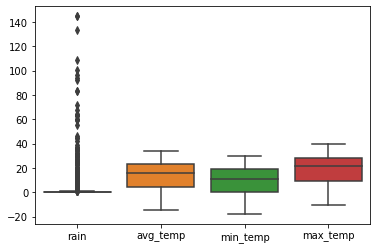

In [7]:
import seaborn as sns
sns.boxplot( data = train_x)

In [8]:
# yyyy-mm-dd에서 년도와 월 데이터 생성
def processing(df):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df.drop(['date'], axis = 1, inplace = True)
    return df

In [9]:
train_x = processing(train_x)
test_x =processing(test_x)

In [10]:
train_x

,rain,avg_temp,min_temp,max_temp,month
0,0.0,-7.9,-10.9,-4.5,12
1,0.4,2.7,-5.7,6.8,12
2,1.4,3.8,1.1,6.2,12
3,0.0,-1.7,-4.6,2.6,12
4,0.0,2.0,-2.7,6.6,12
...,...,...,...,...,...
1011,9.5,16.3,13.0,18.6,5
1012,7.5,18.9,10.2,26.9,5
1013,0.0,15.7,10.2,20.6,5
1014,27.0,12.9,8.9,17.6,5


In [11]:
# 전처리 
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np

sc = StandardScaler()

def pre_sc(df):
    sc = StandardScaler()
    sc.fit(df.iloc[:,1:4] )
    df.iloc[:,1:4] = sc.transform(df.iloc[:,1:4])
    return df

In [12]:
train_x = pre_sc(train_x)
test_x = pre_sc(test_x)

In [13]:
test_x.describe()

,rain,avg_temp,min_temp,max_temp,month
count,300.000000,3.000000e+02,3.000000e+02,3.000000e+02,300.000000
mean,2.582667,-7.401487e-19,1.961394e-16,-1.310063e-16,6.810000
std,10.368629,1.001671e+00,1.001671e+00,1.001671e+00,3.355308
min,0.000000,-2.631834e+00,-2.443905e+00,-2.655367e+00,1.000000
25%,0.000000,-9.081466e-01,-8.527101e-01,-8.903454e-01,4.000000
50%,0.000000,2.440508e-01,2.187247e-01,2.848118e-01,7.000000
75%,0.100000,8.086275e-01,8.342297e-01,7.969425e-01,9.250000
max,124.500000,1.764951e+00,1.814478e+00,1.679454e+00,12.000000


In [14]:
train_x[(train_x['rain']==0)].describe()

,rain,avg_temp,min_temp,max_temp,month
count,708.0,708.000000,708.000000,708.000000,708.000000
mean,0.0,-0.077009,-0.117550,-0.032808,6.591808
std,0.0,1.022390,0.995315,1.034762,3.467577
min,0.0,-2.622272,-2.476930,-2.663765,1.000000
25%,0.0,-0.985679,-0.997950,-0.984576,4.000000
50%,0.0,0.100073,0.014927,0.177594,6.000000
75%,0.0,0.810249,0.714082,0.845223,10.000000
max,0.0,1.784467,1.807630,1.859030,12.000000


In [15]:
# 비가 온날과 안 온날의 구분
train_x['rain_flg'] = train_x.loc[:,'rain'].apply(lambda x : 0 if x == 0 else 1)
test_x['rain_flg'] = test_x.loc[:,'rain'].apply(lambda x : 0 if x == 0 else 1)

## 모델링

In [18]:
from sklearn.model_selection import train_test_split

train_x.drop(['rain'], axis = 1)
y = train_y['mosquito_ratio']

X_train, X_val, y_train, y_val = train_test_split(train_x, y, test_size = 0.2, random_state = 12)
print(X_train.shape, X_val.shape,y_train.shape, y_val.shape)

(812, 6) (204, 6) (812,) (204,)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf = RandomForestRegressor(random_state = 123)
XGB = XGBRFRegressor(random_state = 123)

def fit_model(model, trainx, trainy, testx, testy):
    model.fit(trainx, trainy)
    pred = model.predict(testx)
    print('{0}_rmse: {1:.4f}'.format(model, mean_squared_error(testy, pred, squared = False)))
    print('{0}_r2 : {1:.4f}'.format(model, r2_score(testy, pred)))

In [20]:
for model in [rf, XGB]:
    fit_model(model, X_train,y_train, X_val, y_val)

RandomForestRegressor(random_state=123)_rmse: 115.8449
RandomForestRegressor(random_state=123)_r2 : 0.8645
XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=100,
               objective='reg:squarederror', random_state=123, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)_rmse: 113.1582
XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=10

강수량 자체를 넣었을 때보다 강수 더미 변수를 넣을 때 조금 더 좋은 결과가 나왔지만, 큰 차이는 없다.  
< 강수량 자체를 넣었을 때 결과>
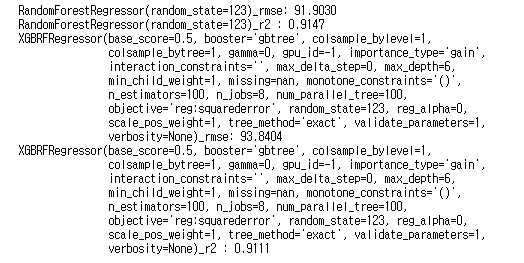